![logo](img/quest.svg)
# QuestDB Tutorial for Python

## Getting Started

To get started, you'll need a few things installed and set up. This should be quick. 

1. QuestDB: To install Questdb you can see [Installation](https://questdb.io/getstarted) for complete instructions in case you want to use Docker, or `brew` on MacOS, but the easiest way is to download the binaries and run it directly. Instructions for that are [Here](https://questdb.io/docs/guideBinaries).
2. Jupyter Notebooks: That's what this is. To run it, you should:
    1. make **sure** you are running Python 3.x and _not_ Python 2.7. If you're in doubt, `python --version` will tell you.
    2. install Jupyter Notebooks with `pip3 install --upgrade ipython jupyter`
    3. make sure that the libraries we use in this tutorial are also installed with `pip3 install requests urlib matplotlib pandas`
    4. clone this repository (`git clone https://github.com/davidgs/QuestNotebook`)
    5. in the repository directory run `jupyter notebook`
   
That will get you right back to a page like this that is interactive, allowing you to run the code and interact with the database yourself.

If you get errors like `ModuleNotFoundError: No module named 'requests'` for any of the libraries you installed above, double-check to make sure that you are actually using Python 3.x `jupytper --path` will let you know if Jupyter is using 2.7 or 3.x

## Create A Database

We will need someplace to store our data, so let's create a test database where we can put some random data.

We will create a simple table with 5 columns, one of which is a `timestamp` 

The Create operation in QuestDB appends records to bottom of a table. If the table has a designated `timestamp`, new record timestamps must be superior or equal to the latest timestamp. Attempts to add a timestamp in middle of a table will result in a timestamp out of order error.

* `cust_id` is the customer identifier. It uniquely identifies customer.
* `balance_ccy` balance currency. We use `SYMBOL` here to avoid storing text against each record to save space and increase database performance.
* `balance` is the current balance for customer and currency tuple.
* `inactive` is used to flag deleted records.
* `timestamp` timestamp in microseconds of the record. Note that if you receive the timestamp data as a string, it could also be inserted using `to_timestamp`.

This should return a `200` status the first time you run it. If you run it more than once, subsequent runs will return `400` because the database already exists.

In [2]:
import requests
import urllib.parse as par

q = 'create table balances'\
    '(cust_id int,'\
    ' balance_ccy symbol,'\
    'balance double,'\
    'inactive boolean,'\
    'timestamp timestamp)'\
    'timestamp(timestamp)'
r = requests.get("http://localhost:9000/exec?query=" + q)
print(r.status_code)

400


## Generate some Data

Since we have a new setup, we should add some data to QuestDB so that we can have something to query. We will add some random data, for now. 

You can re-run this section as many times as you want to add 100 entries at a time, or simply change the `range(100)` to add as many datapoints as you wish.


In [3]:
import requests
import random
from datetime import datetime
success = 0
fail = 0
currency = ["USD", "EUR", "GBP", "JPY"]
random.seed()
for x in range(100):
    cust = random.randint(20, 42)
    cur = random.choice(currency)
    bal = round(random.uniform(10.45, 235.15), 2)
    act = bool(random.getrandbits(1))
    query = "insert into balances values("\
        + str(cust) + ",'"\
        + cur + "'," \
        + str(bal) + "," \
        + str(act) + ",systimestamp())"
    r = requests.get("http://localhost:9000/exec?query=" + query)
    if r.status_code == 200:
        success += 1
    else:
        fail += 1
    
print("Rows inserted: " + str(success))
if fail > 0:
    print("Rows Failed: " + str(fail))
    

Rows inserted: 100


## Query Data from QuestDB

Now that we have data available, let's try querying some of it to see what we get back!

In [4]:
import requests
import io

r = requests.get("http://localhost:9000/exp?query=select * from  balances")
rawData = r.text
print(rawData)


"cust_id","balance_ccy","balance","inactive","timestamp"
41,"EUR",176.26,false,"2023-04-04T08:33:37.199924Z"
24,"USD",22.8,true,"2023-04-04T08:33:37.227209Z"
20,"JPY",196.9,true,"2023-04-04T08:33:37.234661Z"
27,"GBP",179.42,true,"2023-04-04T08:33:37.240217Z"
29,"JPY",58.33,false,"2023-04-04T08:33:37.246586Z"
20,"EUR",218.45,false,"2023-04-04T08:33:37.252595Z"
24,"GBP",122.07,true,"2023-04-04T08:33:37.257652Z"
30,"GBP",198.02,false,"2023-04-04T08:33:37.266283Z"
35,"GBP",166.43,false,"2023-04-04T08:33:37.271736Z"
28,"USD",233.04,false,"2023-04-04T08:33:37.280146Z"
38,"GBP",87.66,false,"2023-04-04T08:33:37.285478Z"
39,"JPY",95.64,false,"2023-04-04T08:33:37.292720Z"
40,"USD",94.59,false,"2023-04-04T08:33:37.297769Z"
37,"JPY",172.65,false,"2023-04-04T08:33:37.303147Z"
21,"JPY",146.77,false,"2023-04-04T08:33:37.308450Z"
38,"JPY",60.38,true,"2023-04-04T08:33:37.315842Z"
41,"USD",219.01,false,"2023-04-04T08:33:37.322261Z"
32,"USD",184.18,true,"2023-04-04T08:33:37.326963Z"
41,"JPY",170.0,false,

## Read the content into Pandas Dataframe

So you'll notice that the returned data is just a massive `csv` string. If you'd rather have `json` data, then you would change the endpoint to `http://localhost:9000/exec ...` But since we're going to use Pandas to frame our data, we'll stick with `csv`.

We are also telling pandas to parse the `timestamp` field as a date. This is important since we're dealing with Time Series data.

In [5]:
import pandas as pd

pData = pd.read_csv(io.StringIO(rawData), parse_dates=['timestamp'])
print(pData)


    cust_id balance_ccy  balance  inactive                        timestamp
0        41         EUR   176.26     False 2023-04-04 08:33:37.199924+00:00
1        24         USD    22.80      True 2023-04-04 08:33:37.227209+00:00
2        20         JPY   196.90      True 2023-04-04 08:33:37.234661+00:00
3        27         GBP   179.42      True 2023-04-04 08:33:37.240217+00:00
4        29         JPY    58.33     False 2023-04-04 08:33:37.246586+00:00
..      ...         ...      ...       ...                              ...
95       40         EUR    80.80      True 2023-04-04 08:33:37.958451+00:00
96       33         JPY    73.09      True 2023-04-04 08:33:37.963797+00:00
97       21         GBP    69.73     False 2023-04-04 08:33:37.972450+00:00
98       37         USD    64.05      True 2023-04-04 08:33:37.978270+00:00
99       23         JPY    11.74     False 2023-04-04 08:33:37.985176+00:00

[100 rows x 5 columns]


## Narrow the search

That's just getting us *all* the data, but let's narrow the search using some SQL clauses. Let's look for a specific `cust_id` and only balances of that customer that are in $s. We are also only interested in times the customer was `active` Since this is SQL, you can make this query as simple, or as complex, as you'd like.

Since all of the data was generated randomly, this exact query may return no results, so you may have to adjust the `cust_id` below until you get results back. 

***Note:** The query string _must_ be URL-encoded before it is sent.

In [9]:
import urllib.parse

q = "select cust_id,"\
    " balance,"\
    " balance_ccy,"\
    " inactive,"\
    " timestamp"\
    " from balances"\
    " where cust_id = 21"
query = urllib.parse.quote(q)
r = requests.get("http://localhost:9000/exp?query=" + query)
queryData = r.content
rawData = pd.read_csv(queryData.decode('utf-8'), parse_dates=['timestamp'])
print(rawData)

FileNotFoundError: [Errno 2] No such file or directory: '"cust_id","balance","balance_ccy","inactive","timestamp"\r\n21,146.77,"JPY",false,"2023-04-04T08:33:37.308450Z"\r\n21,49.33,"GBP",true,"2023-04-04T08:33:37.717813Z"\r\n21,69.73,"GBP",false,"2023-04-04T08:33:37.972450Z"\r\n'

## Plot the data

We will use `matplotlib` to plot the data

array([<Axes: xlabel='timestamp'>], dtype=object)

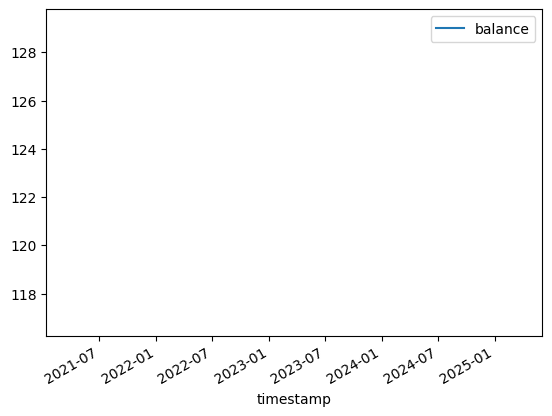

In [21]:
from matplotlib import pyplot as plt

rawData.plot("timestamp", ["balance"], subplots=True)



## Clean up

Now we will clean everything up for the next time. 

In [19]:
r = requests.get("http://localhost:9000/exec?query=drop table balances")
if r.status_code == 200:
    print("Database Table dropped")
else:
        print("Database Table not Dropped: " + str(r.status_code))

Database Table not Dropped: 400
